<a href="https://colab.research.google.com/github/KamilS25/ISiT/blob/main/Pr1_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Практическая работа №1**. Классификация методом к-ближайших соседей
**Группа**: БСМО-11-25
**Рабочая группа**: Салахетдинов Камиль, Пылин Олег, Дели Валерия, Мокрецов Егор(БСМО-12-25)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

**Первичная обработка данных**


In [39]:
df = pd.read_csv('Датасет CSV.csv', sep='\t', encoding='utf-8')

columns = [
    'phone_os', 'gender', 'siblings', 'pc_os', 'taxi_rides',
    'mobile_games', 'living_area', 'camera_important', 'federal_district',
    'payment_method', 'phone_change_years', 'employment', 'smart_home',
    'it_work', 'watch_type', 'max_budget', 'charges_per_day',
    'browser', 'love_tech', 'customize_important', 'material_important'
] # С кириллицей работать неудобно, поэтому переименовали столбцы
df.columns = columns

print(df.head())
print(f"Размер датасета: {df.shape}")

print(f"Проверка на пропуски: {df.isnull().sum().sum()}")

   phone_os  gender  siblings  pc_os  taxi_rides  mobile_games  living_area  \
0         1       1         1      1          20             1            5   
1         1       2         0      2          15             2            4   
2         1       1         2      1           1             2            4   
3         2       1         0      1           0             2            7   
4         1       1         0      1           0             2            4   

   camera_important  federal_district  payment_method  ...  employment  \
0                 1                 1               1  ...           2   
1                 1                 6               1  ...           2   
2                 1                 1               1  ...           3   
3                 1                 1               1  ...           2   
4                 1                 1               1  ...           3   

   smart_home  it_work  watch_type  max_budget  charges_per_day  browser  \
0   

**Нормализация данных методом Min-Max Scaling**

Суть данной нормализации заключается в том, чтобы привести все данные к единому виду (значения от 0 до 1)

1. Находим наименьшую переменную и наибольшую

2. Расчет по формуле x_normalized = (x - min) / (max - min)

In [40]:
def normalize_data(df):
    df_normalized = df.copy()
    for column in df_normalized.columns:
        if column != 'phone_os':  # Целевая переменная не нормализуется
            min_val = df_normalized[column].min()
            max_val = df_normalized[column].max()
            if max_val != min_val:
                df_normalized[column] = (df_normalized[column] - min_val) / (max_val - min_val)
    return df_normalized

df_normalized = normalize_data(df)
print("Нормализованные данные:")
print(df_normalized.head())

Нормализованные данные:
   phone_os  gender  siblings  pc_os  taxi_rides  mobile_games  living_area  \
0         1     0.0       0.2    0.0    0.285714           0.0          0.6   
1         1     1.0       0.0    0.5    0.214286           1.0          0.4   
2         1     0.0       0.4    0.0    0.014286           1.0          0.4   
3         2     0.0       0.0    0.0    0.000000           1.0          1.0   
4         1     0.0       0.0    0.0    0.000000           1.0          0.4   

   camera_important  federal_district  payment_method  ...  employment  \
0               0.0               0.0             0.0  ...         0.5   
1               0.0               1.0             0.0  ...         0.5   
2               0.0               0.0             0.0  ...         1.0   
3               0.0               0.0             0.0  ...         0.5   
4               0.0               0.0             0.0  ...         1.0   

   smart_home  it_work  watch_type  max_budget  charges_

**Разделение на обучающую и тестовую выборки**

Берем 30% от датасета рандомным образом в качестве обучающих данных

In [41]:
def train_test_split(df, test_size=0.3, random_state=None):
    if random_state:
        np.random.seed(random_state)

    n = len(df)
    test_indices = np.random.choice(n, size=int(n * test_size), replace=False)
    train_indices = [i for i in range(n) if i not in test_indices]

    X_train = df.iloc[train_indices, 1:].values  # Все признаки кроме phone_os
    y_train = df.iloc[train_indices, 0].values   # phone_os
    X_test = df.iloc[test_indices, 1:].values
    y_test = df.iloc[test_indices, 0].values

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df_normalized, test_size=0.3, random_state=42)

print("Размеры выборок:")
print(f"Обучающая: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Тестовая: X_test {X_test.shape}, y_test {y_test.shape}")

Размеры выборок:
Обучающая: X_train (24, 20), y_train (24,)
Тестовая: X_test (9, 20), y_test (9,)


**Реализация метода к-ближайших соседей**

1. **Вычисление расстояний**: Евклидово расстояние  √Σ(x_i - y_i)²
2. **Соседи**: Смотрим на ближайших соседей и подсчитываем их в словаре, проводятся испытания с разным количеством соседей, но берем только нечетные, чтобы не возникло ситуации, когда у нас одинаковое количество соседей у одной метки
3. **Итог**: Присваиваем класс метке в зависимости от соседей

In [42]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def calculate_distance(self, x1, x2):
        """Вычисление расстояния между двумя точками"""
        return np.sqrt(np.sum((x1 - x2) ** 2))


    def fit(self, X, y):
        """Сохраняем обучающие данные"""
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """Предсказание для набора данных"""
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        """Предсказание для одного образца"""
        # Вычисляем расстояния до всех точек обучающей выборки
        distances = [self.calculate_distance(x, x_train) for x_train in self.X_train]

        # Получаем индексы k ближайших соседей
        k_indices = np.argsort(distances)[:self.k]

        # Получаем метки k ближайших соседей
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Возвращаем наиболее частую метку
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

**Обучение и оценка точности модели для разного количества соседей**

**Метрика**: точность (Кол-во правильных) / (Всего)
         = TP + TN / (TP + TN + FP + FN)

In [43]:
k_values = range(1, 16, 2)
accuracies = []

print("Точность для разных k:")
print("k\tТочность")
print("-" * 15)

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)

    accuracy = np.sum(predictions == y_test) / len(y_test)
    accuracies.append(accuracy)
    print(f"{k}\t{accuracy:.4f}")

Точность для разных k:
k	Точность
---------------
1	0.7778
3	0.5556
5	0.5556
7	0.5556
9	0.4444
11	0.5556
13	0.4444
15	0.6667


**Визуализация результатов**

График зависимости точности от количества соседей

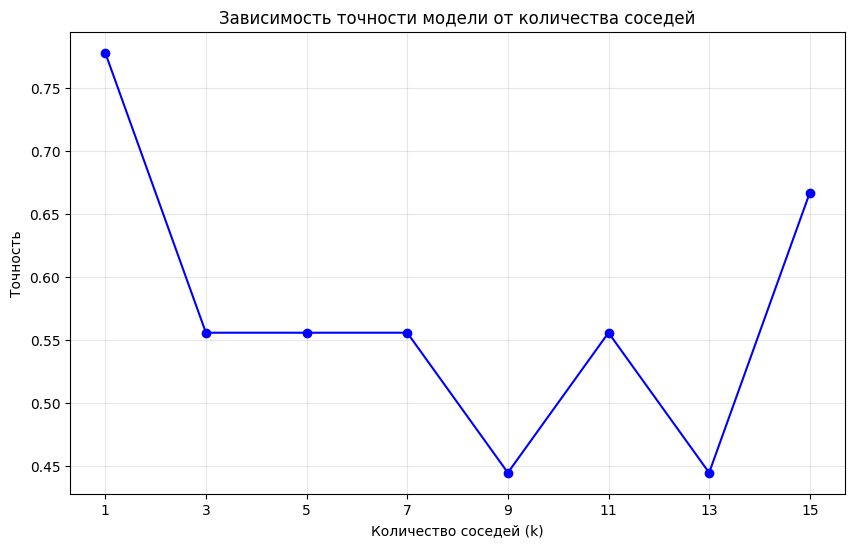

In [44]:

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Зависимость точности модели от количества соседей')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()

**Анализ важности признаков**

Проводим предсказания, последовательно исключая признаки и сравниваем результаты

**Формула**: Точность со всеми - точность без признака.

In [55]:
def feature_importance_analysis(df, k=5, n_iterations=10):
    """Анализ важности признаков путем их последовательного исключения"""
    feature_names = df.columns[1:]  # Все признаки кроме целевого
    base_accuracies = []
    feature_importance = {}

    print("Топ-5 самых важных признаков:")
    print("Признак\t\t\tСредняя точность")
    print("-" * 60)

    # Базовая точность со всеми признаками
    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(df_normalized, test_size=0.3, random_state=i)
        knn = KNNClassifier(k=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)
        base_accuracy = np.sum(predictions == y_test) / len(y_test)
        base_accuracies.append(base_accuracy)

    base_avg_accuracy = np.mean(base_accuracies)

    # Оценка важности каждого признака
    for feature_name in feature_names:
        accuracies_without_feature = []

        for i in range(n_iterations):
            # Создаем копию данных без текущего признака
            temp_df = df_normalized.drop(columns=[feature_name])

            # Разделяем данные без этого признака
            X_train_temp = temp_df.iloc[:, 1:].values  # Все признаки кроме phone_os
            y_train_temp = temp_df.iloc[:, 0].values   # phone_os

            n = len(temp_df)
            test_indices = np.random.choice(n, size=int(n * 0.3), replace=False)
            train_indices = [i for i in range(n) if i not in test_indices]

            X_train = X_train_temp[train_indices]
            X_test = X_train_temp[test_indices]
            y_train = y_train_temp[train_indices]
            y_test = y_train_temp[test_indices]

            knn = KNNClassifier(k=k)
            knn.fit(X_train, y_train)
            predictions = knn.predict(X_test)
            accuracy = np.sum(predictions == y_test) / len(y_test)
            accuracies_without_feature.append(accuracy)

        avg_accuracy_without = np.mean(accuracies_without_feature)
        importance = base_avg_accuracy - avg_accuracy_without
        feature_importance[feature_name] = importance


    sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

    for feature, importance in sorted_features[:5]:
        print(f"{feature}: \t\t{importance:.4f}")

    return sorted_features


**Вывод результатов по определению самых важных признаков**

In [56]:
important_features = feature_importance_analysis(df, k=5)
print("\n" + "="*60)
print("Сравнение точности модели со всеми признаками и без важных")
print("="*60)

# Модель со всеми признаками
X_train, X_test, y_train, y_test = train_test_split(df_normalized, test_size=0.3, random_state=42)
knn_full = KNNClassifier(k=5)
knn_full.fit(X_train, y_train)
predictions_full = knn_full.predict(X_test)
accuracy_full = np.sum(predictions_full == y_test) / len(y_test)

# Модель без топ-3 важных признаков
top_3_important = [feature for feature, _ in important_features[:3]]
print(f"Удаляем 3 самых важных признака: {top_3_important}")

columns_to_keep = ['phone_os'] + [col for col in df_normalized.columns if col not in top_3_important and col != 'phone_os']
df_reduced = df_normalized[columns_to_keep]

X_train_red = df_reduced.iloc[:, 1:].values
y_train_red = df_reduced.iloc[:, 0].values

n = len(df_reduced)
test_indices = np.random.choice(n, size=int(n * 0.3), replace=False)
train_indices = [i for i in range(n) if i not in test_indices]

X_train_red_final = X_train_red[train_indices]
X_test_red_final = X_train_red[test_indices]
y_train_red_final = y_train_red[train_indices]
y_test_red_final = y_train_red[test_indices]

knn_reduced = KNNClassifier(k=5)
knn_reduced.fit(X_train_red_final, y_train_red_final)
predictions_reduced = knn_reduced.predict(X_test_red_final)
accuracy_reduced = np.sum(predictions_reduced == y_test_red_final) / len(y_test_red_final)

print("Результаты:")
print(f"Точность со всеми признаками: {accuracy_full:.4f}")
print(f"Точность без важных признаков: {accuracy_reduced:.4f}")
print(f"Разница в точности: {accuracy_full - accuracy_reduced:.4f}")

Топ-5 самых важных признаков:
Признак			Средняя точность
------------------------------------------------------------
it_work: 		-0.1556
customize_important: 		-0.1556
mobile_games: 		-0.1333
camera_important: 		-0.1333
pc_os: 		-0.1111

Сравнение точности модели со всеми признаками и без важных
Удаляем 3 самых важных признака: ['it_work', 'customize_important', 'mobile_games']
Результаты:
Точность со всеми признаками: 0.5556
Точность без важных признаков: 0.2222
Разница в точности: 0.3333


**Выводы**

1. Модель показала наилучший результат при одном соседе (78%), это обуславливается тем, что у нас маленький датасет, в котором мало шума. В реальности, при большем датасете оптимально выбирать большее количество соседей. В основном, на данной моделе приемлимо использовать 5, 7, 9 соседей (56%). Да, точность кажется плохой, но это характеризуется тем, что датасет очень маленький.
2. Было выявлено 5 самых важных признаков:
*   it_work (работа в IT) - IT специалисты больше предпочитают Android (с реальным миром не особо коррелирует будто)
*   customize_important (важность кастомизации) - тут ничего удивительно, пользователи Android предпочитают настройку интерфейса, так как данная ОС это позволяет
* mobile_games (игры в мобильные игры) - скорее всего, играет роль высокой производительности. Iphone
*camera_important (важность камеры) - пользователи, которым важна камера больше предпочитают Iphone
*pc_os (операционная система на ПК) - тут логично, так как Mac предоставляет возможность использования экосистемы вместе с использованием Iphone, Android пользователям это не так важно
3. Было проведено тестирование без трех самых важных признаков, результаты отличались на 33%.

Исследование было проведено на маленьком датасете, который состоит из 33 опрошенных, такое количество данных является катастрофически маленьким для заключения о точности. Цель изучения алгоритма классификации к-ближайших соседей была достигнута, так как был написан и проанализирвоан данный алгоритм.
